# Numerics 1: Homework 04

## Cooper Simpson

## Setup

In [ ]:
#Theme
from jupyterthemes import jtplot
!jt -t grade3
jtplot.style()

In [ ]:
!jt -r;

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set()

In [28]:
#Defining our functions

#funcs is list of callable functions that define system
def rk4(funcs, t, y):
    num_funcs = y.shape[1]
    if num_funcs != len(funcs):
        raise ValueError('Number of functions dont match number of initial conditions!')
    
    h = t[1]-t[0] #Assuming everything is evenly spaced
    K = np.zeros((4, num_funcs)) #K's
                 
    for i in range(len(t)-1):
        #Iterate and evaluate
        #K's
        for j in range(num_funcs):
            K[0,j] = h*funcs[j](t[i], y[i,:])
        for j in range(num_funcs):
            K[1,j] = h*funcs[j](t[i]+(h/2), y[i,:]+(K[0,:]/2))
        for j in range(num_funcs):
            K[2,j] = h*funcs[j](t[i]+(h/2), y[i,:]+(K[1,:]/2))
        for j in range(num_funcs):
            K[3,j] = h*funcs[j](t[i]+h, y[i,:]+K[2,:])

        #Next point
        y[i+1,:] = y[i,:] + (1/6)*(K[0,:]+2*K[1,:]+2*K[2,:]+K[3,:])
                 
    return y


#Adams-Bashforth coefficients
ab_coeff = {2:[3/2, -1/2],
            4:[55/24, -59/24, 37/24, -9/24]}

#Assuming that 
def adam_bash(func, t, y, pts=3, seed=None, single=False):
    h = t[1]-t[0]
    #If values are not pre-seeded
    if callable(seed):
        y[1:pts] = seed(t[1:pts])
        
    for i in range(pts-1, len(t)-1):
        y[i+1] = y[i]
        for j in range(pts):
            y[i+1] += h*ab_coeff[pts][j]*func(t[i-j], y[i-j])
            
    if single: return y[-1]
    else: return y


#Adams-Moulton coefficients
am_coeff = {2:[5/12, 8/12, -1/12],
            3:[9/24, 19/24, -5/24, 1/24]}

#future is etheir a function or a value
def adam_moult(func, t, y, future, pts=2, seed=None, single=False):
    h = t[1]-t[0]
    #If values are not pre-seeded
    if callable(seed):
        y[1:pts] = seed(t[1:pts])
        
    for i in range(pts-1, len(t)-1):
        if callable(future):
            y[i+1] = future(am_coeff[pts], x[i+1-pts:i+2], y[i+1-pts:i+1], h, func)
        else:
            y[i+1] = y[i] + h*am_coeff[pts][0]*func(t[i], future)
            for j in range(pts):
                y[i+1] += h*am_coeff[pts][j+1]*func(t[i-j], y[i-j])
  
    if single: return y[-1]
    else: return y

def pred_corrector(func, predictor, corrector, x, y, pts=(4,3), seed=None, correct_seed=False):
    #If values are not pre-seeded
    if callable(seed):
        y[1:pts[0]] = seed(x[1:pts[0]])
    elif seed == 'rk4':
        y0 = y[:pts[0]].reshape((pts[0], 1))
        y0 = rk4([func], x[:pts[0]], y0)
        y[:pts[0]] = y0.reshape(pts[0])
        
    #Correct the last seed value
    if correct_seed:
        y[pts[0]-1] = corrector(func, x[0:pts[0]], y[0:pts[0]], future=y[pts[0]], pts=pts[1], single=True)
        
    for i in range(pts[0], len(x)):
        pred = predictor(func, x[i-pts[0]:i+1], y[i-pts[0]:i+1], pts=pts[0], single=True)
        corr = corrector(func, x[i-pts[1]:i+1], y[i-pts[1]:i+1], future=pred, pts=pts[1], single=True)
        y[i] = corr
        
    return y

## Problem 1
We use the "direct method" to determine the weighting coefficients for the following expression in numerical integration:

$$ \int_0^1 f(x)\;dx\approx af(\frac{1}{3})+bf(\frac{2}{3}) $$

The direct method involves plugging in successive powers of $x$ as the function $f$ to determine a linear system that can be solved for the weighting coefficients. This means assuming $f(x)=1,x,x^2,\ldots$ and evaluating both sides of the above equation.

$$
\begin{align}
    &f(x)=1\implies 1=a+b\\
    &f(x)=x\implies \frac{1}{2}=\frac{a}{3}+\frac{2b}{3}\\
    &f(x)=x^2\implies \frac{1}{3}=\frac{a}{9}+\frac{4b}{9}
\end{align}
$$

We only need to use the first two equations to determine our two unknowns. The first tells us $a=1-b$ which upon  plugging into the second tells us $\frac{3}{2}=1-b+2b$. This implies that $\boxed{b=\frac{1}{2}=a}$. Plugging this into the third equation we can see that it is inconsistent as $1\neq \frac{5}{6}$. Our final equation is as follows:

$$ \int_0^1 f(x)\;dx\approx \frac{1}{2}f(\frac{1}{3})+\frac{1}{2}f(\frac{2}{3}) $$

We may note that this answer intuitively makes sense as we are equally weighting our function values across the interval.

## Problem 2
We use the fourth order Runge-Kutta method to solve a coupled system of ODE's.

We consider the interval $0\leq t\leq1$ with a step size of $h=0.2$ in the following system of coupled ODE's.

$$
\begin{align}
    &u_1'=3u_1+2u_2-(2t^2+1)e^{2t}\\
    &u_2'=4u_1+u_2+(t^2+2t-4)e^{2t}
\end{align}
$$

We have initial conditions of $u_1(0)=1$ and $u_2(0)=1$, and we note that the exact solutions are given as follows:

$$
\begin{align}
    &u_1(t)=\frac{1}{3}e^{5t}-\frac{1}{3}e^{-t}+e^{2t}\\
    &u_2(t)=\frac{1}{3}e^{5t}+\frac{2}{3}e^{-t}+t^2e^{2t}
\end{align}
$$

In [68]:
def du1(t, Y):
    return 3*Y[0] + 2*Y[1] - (2*(t**2)+1)*np.exp(2*t)

def du2(t, Y):
    return 4*Y[0] + Y[1] + (t**2+2*t-4)*np.exp(2*t)

def u1(t):
    return (1/3)*np.exp(5*t)-(1/3)*np.exp(-t)+np.exp(2*t)

def u2(t):
    return (1/3)*np.exp(5*t)+(2/3)*np.exp(-t)+(t**2)*np.exp(2*t)

In [69]:
h = 0.2
t = np.arange(0,1+h,h)
y = np.zeros((len(t), 2))
y[0,0] = 1
y[0,1] = 1

y = rk4((du1,du2), t, y)

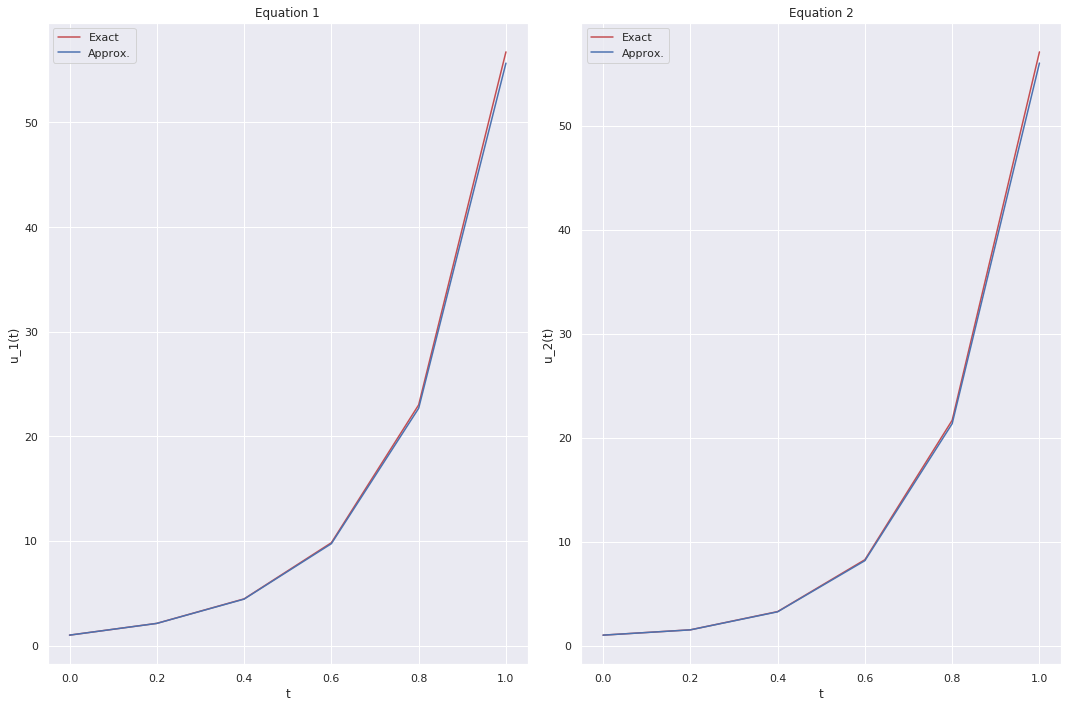

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].plot(t, u1(t), 'r')
ax[0].plot(t, y[:,0], 'b')
ax[0].set_xlabel('t')
ax[0].set_ylabel('u_1(t)')
ax[0].set_title('Equation 1')
ax[0].legend(['Exact', 'Approx.'])

ax[1].plot(t, u2(t), 'r')
ax[1].plot(t, y[:,1], 'b')
ax[1].set_xlabel('t')
ax[1].set_ylabel('u_2(t)')
ax[1].set_title('Equation 2')
ax[1].legend(['Exact', 'Approx.'])
plt.tight_layout()

In the above plots we can see the solutions to our coupled system plotted over the interval of interest. We see the analytic solution plotted in red and the approximate numerical solution plotted in blue. It is clear to see that our numerical approximation is quite accurate, although the error is beginning to increase near the end of the interval. We also note that the approximation is quite accurate despite the large step size of $0.2$, so it would be quite easy to improve upon the performance.

## Problem 3
We consider the differential equation $y'=x+y$ with $y(0)=0$. We will solve this equation numerically with a variety of implicit and explicit methods, as well as a combination of the two.

We consider $0\leq x\leq0.5$ and a step size of $h=0.1$. We will begin by first solving this equation analytically for the purposes of verification.

We use an integrating factor of $\mu=e^{-x}$ and multiply through on both sides.

$$ \implies e^{-x}(y'-y)=xe^{-x} $$

Noting the product rule on the left hand side we can say $\frac{d}{dx}ye^{-x}=xe^{-x}$. Integrating both sides and using IBP on the RHS with $u=x,\;du=1,\;dv=e^{-x},\;v=-e^{-x}$ we get the following:

$$ ye^{-x}=-xe^{-x}-e^{-x}+C $$

Simplification and the initial condition then yields $y(x)=e^x-x-1$. Plugging this into the original equation it is clear to see that it holds.

We also note that -- where necessary -- we have used the approximation $y\approx\frac{x^2}{2}$ for seed values where $x<<1$.

In [29]:
h = 0.1
x = np.arange(0,0.5+h,h)
y = np.zeros(len(x)) #Implicitly sets IC

#Derivative
def df(x, y):
    return x + y

#Exact Solution
def f(x):
    return np.exp(x)-x-1

#Seed function
def seedf(x):
    return (x**2)/2

### a). Adams-Bashforth 2pt
We note that this is an explicit method with two points of history.

In [30]:
y_ab = adam_bash(df, x, y, pts=2, seed=seedf)

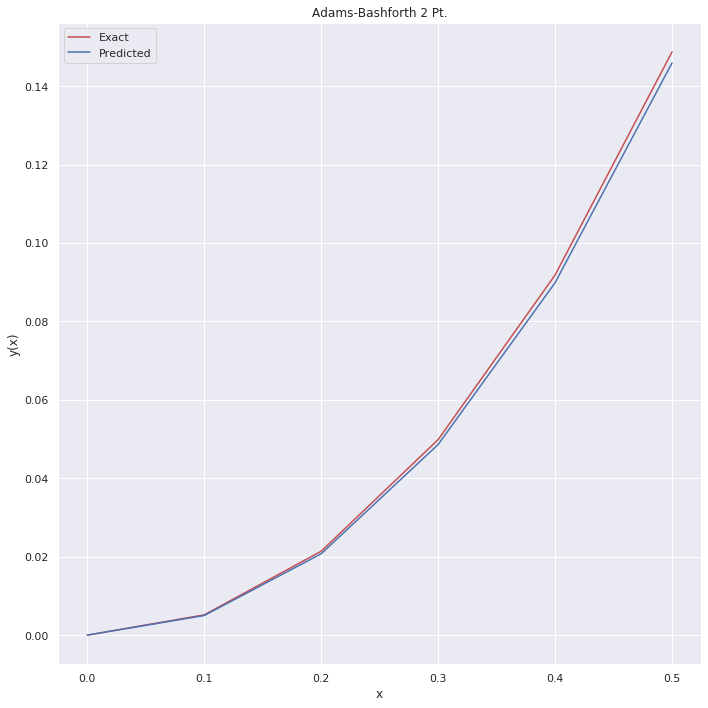

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x, f(x), 'r')
ax.plot(x, y_ab, 'b')
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.set_title('Adams-Bashforth 2 Pt.')
ax.legend(['Exact', 'Predicted'])
plt.tight_layout()

In the above plot we see the exact solution plotted in red and the numerical approximation plotted in blue. We can see that our method does fairly well, but that there is definitely some accumulating error.

### b). Adams-Moulton 2pt
We note that this is an implicit method with two points of history and one future point.

Because this is an implicit method we must first algebraically solve for the future point as a function of the past points. The Adams-Moulton two point equation is $y_{i+1} = y_i + h(af(x_{i+1}, y_{i+1}) + bf(x_i, y_i) + cf(x_{i-1}, y_{i-1}))$. We plug in our known form for $f$ and solve for $y_{i+1}$:

$$ 
\begin{align}
    &y_{i+1} = y_i + h(a(x_{i+1} + y_{i+1}) + b(x_i + y_i) + c(x_{i-1} + y_{i-1}))\\
    &y_{i+1} = \frac{1}{1-ha}(y_i + hax_{i+1} + hb(x_i + y_i) + hc(x_{i-1} + y_{i-1}))
\end{align}
$$

In [32]:
def implicit(coeff, x, y, h, func):
    fact = 1/(1-h*coeff[0])
    
    return fact*(y[-1] + h*coeff[0]*x[-1] + h*coeff[1]*(x[-2]+y[-1]) + h*coeff[2]*(x[-3]+y[-2]))

y_am = adam_moult(df, x, y, implicit, pts=2, seed=seedf)

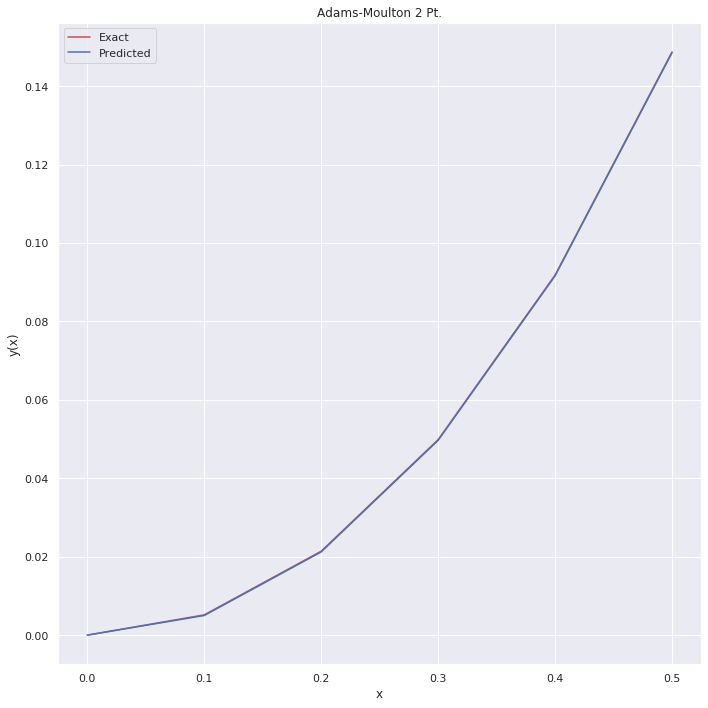

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x, f(x), 'r')
ax.plot(x, y_am, 'b')
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.set_title('Adams-Moulton 2 Pt.')
ax.legend(['Exact', 'Predicted'])
plt.tight_layout()

Like the other plots we have seen the analytic solution is in red and the approximation is in blue. In this case it is difficult to identify the red line as the numerical approximation is so accurate. We note that the Adams-Moulton performace exceeds that of the Adams-Bashforth for the same number of historical points. This is to be expected as the Adams-Moulton is really using more information and thus has a smaller error.

### c). Predictor-Corrector

We use a predictor of Adams-Bashforth four point with a corrector of Adams-Moulton three point.

In [36]:
y_pc = pred_corrector(df, adam_bash, adam_moult, x, y, pts=(4,3), seed=seedf)

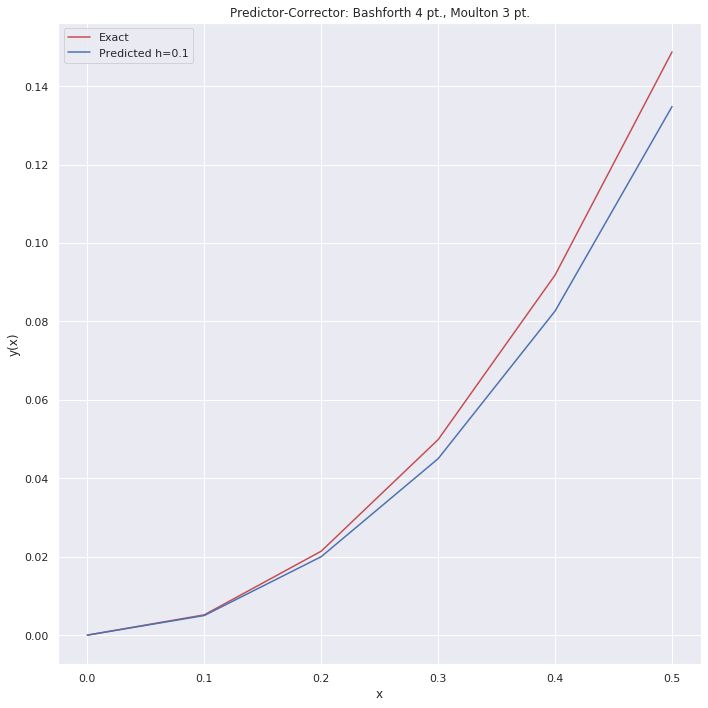

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x, f(x), 'r')
ax.plot(x, y_pc, 'b')
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.set_title('Predictor-Corrector: Bashforth 4 pt., Moulton 3 pt.')
ax.legend(['Exact', 'Predicted h=0.1'])
plt.tight_layout()

Again we see the exact solution plotted in red with the numerical approximation plotted in blue. It is readily clear to see that this method -- predictor-corrector -- provides a worse approximation to the real solution as compared to the previous methods. This is despite the fact that we are using Adams-Bashforth 4 point and Adams-Moulton 3 point which should provide a higher degree of accuracy than the two point methods used previously. This can be explained by the use of our seed function ($y\approx\frac{x^2}{2}$) for values of x that are not $x<<1$. Our fourth seed point is at $x=0.3$ which is not sufficiently small. This problem could be rectified by using a smaller step size or by using a different method to identify the seed values (e.g. Runge-Kutta). Below we show an example of this using a smaller step size of $h=0.005$.

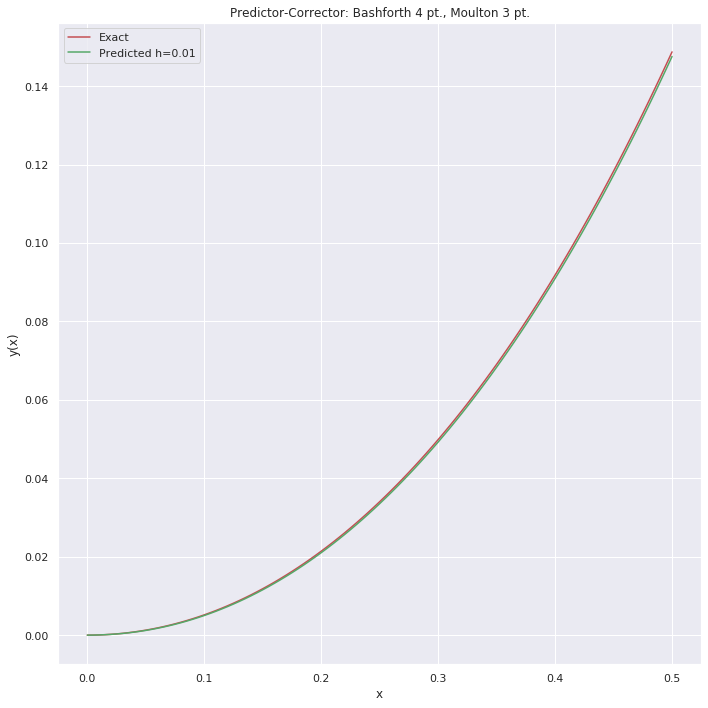

In [40]:
x2 = np.arange(0,0.5+0.005,0.005)
y2 = np.zeros(len(x2)) #Implicitly sets IC
improved = pred_corrector(df, adam_bash, adam_moult, x2, y2, pts=(4,3), seed=seedf)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x2, f(x2), 'r')
ax.plot(x2, improved, 'g')
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.set_title('Predictor-Corrector: Bashforth 4 pt., Moulton 3 pt.')
ax.legend(['Exact', 'Predicted h=0.01'])
plt.tight_layout()

As expected we see that our numerical solution (in green) is much more accurate.